In [ ]:
!nvidia-smi

Mon Sep 11 07:00:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import pickle as pickle
import os
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
# Step 4. 한글 글꼴 설정
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import  pprint
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, Counter
from itertools import chain
from pprint import pprint
# from pycaret.classification import *
# from pycaret.regression import *
# from pycaret.utils import check_metric
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoConfig,AutoModel
from transformers import BertConfig, BertForSequenceClassification, Trainer, TrainingArguments, BertModel, ElectraModel, RobertaModel
from importlib import import_module
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
def seed_everything(seed: int = 42, contain_cuda: bool = False):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Seed set as {seed}")

seed=42
seed_everything(seed)

root_dir = "/content/drive/MyDrive/"
project_folder = "Phising"
os.chdir(os.path.join(root_dir,project_folder))


Seed set as 42


# Utils.py

In [ ]:

from transformers.image_transforms import normalize
def wrong_batch_for_wandb(tokenizer,
                          wrong_sample_index,
                          input_ids,
                          valid_labels,
                          valid_predict,
                          valid_output,
                          ):
    num_to_label_dict = {0:'Normal',1:'Phising'}

    wrong_sample_index = np.where(valid_labels!=valid_predict)[0]
    wrong_sample_text = [tokenizer.decode(element, skip_special_tokens=False) for element in input_ids[wrong_sample_index]]
    wrong_sample_label = [num_to_label_dict[lab] for lab in list(valid_labels[wrong_sample_index])]
    wrong_sample_pred = [num_to_label_dict[pred] for pred in list(valid_predict[wrong_sample_index])]
    wrong_sample_output = valid_output[wrong_sample_index].tolist()

    normal_prob, phising_prob = [], []
    for element in wrong_sample_output:
        normal_prob.append(element[0])
        phising_prob.append(element[1])

    return wrong_sample_text, wrong_sample_label, wrong_sample_pred, normal_prob, phising_prob


# dataloader.py

In [ ]:
def load_data(args, dataset_dir):
    print("===================loading data=====================")
    # load dataset
    dataset = pd.read_csv(dataset_dir)

    # print(dataset)

    return dataset

# bert input을 위한 tokenizing.
def tokenized_dataset(args, dataset, tokenizer):
    lst_comment = dataset['comment'].tolist()
    lst_pos = dataset['pos_keywords'].tolist()

    tokenized_sentences = tokenizer(
        lst_comment,
        lst_pos,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=args.seq_max_len,
        add_special_tokens=True
    )
    return tokenized_sentences

    all_dataset = load_data(args, dataset_dir = f'./data/{args.train_file}')

In [ ]:

# Dataset 구성.
class NLI_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def get_trainLoader(args, train_data, valid_data, train_label, valid_label, tokenizer):

    # entity_between = '</s></s>' if args.model == 'r_roberta' or args.model == 'roberta' else '[SEP]'
    tokenized_train = tokenized_dataset(args, train_data, tokenizer)
    tokenized_valid = tokenized_dataset(args, valid_data, tokenizer)

    # make dataset for pytorch.
    NLI_train_dataset = NLI_Dataset(tokenized_train, train_label)
    NLI_valid_dataset = NLI_Dataset(tokenized_valid, valid_label)

    trainloader = DataLoader(NLI_train_dataset,
                             batch_size=args.batch_size,
                             shuffle=True,
                             num_workers=args.num_workers,
                             )

    validloader = DataLoader(NLI_valid_dataset,
                             batch_size=args.batch_size,
                             shuffle=False,
                             num_workers=args.num_workers,
                             )

    return trainloader, validloader


# optimizer.py

In [ ]:
from torch.optim import Adam, AdamW
from torch.optim.optimizer import Optimizer, required
import math

class AdamP(Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0,
        delta=0.1,
        wd_ratio=0.1,
        nesterov=False,
    ):
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            delta=delta,
            wd_ratio=wd_ratio,
            nesterov=nesterov,
        )
        super(AdamP, self).__init__(params, defaults)

    def _channel_view(self, x):
        return x.view(x.size(0), -1)

    def _layer_view(self, x):
        return x.view(1, -1)

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        return F.cosine_similarity(x, y, dim=1, eps=eps).abs_()

    def _projection(self, p, grad, perturb, delta, wd_ratio, eps):
        wd = 1
        expand_size = [-1] + [1] * (len(p.shape) - 1)
        for view_func in [self._channel_view, self._layer_view]:

            cosine_sim = self._cosine_similarity(grad, p.data, eps, view_func)

            if cosine_sim.max() < delta / math.sqrt(view_func(p.data).size(1)):
                p_n = p.data / view_func(p.data).norm(dim=1).view(expand_size).add_(eps)
                perturb -= p_n * view_func(p_n * perturb).sum(dim=1).view(expand_size)
                wd = wd_ratio

                return perturb, wd

        return perturb, wd

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad.data
                beta1, beta2 = group["betas"]
                nesterov = group["nesterov"]

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p.data)
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                # Adam
                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

                state["step"] += 1
                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(
                    group["eps"]
                )
                step_size = group["lr"] / bias_correction1

                if nesterov:
                    perturb = (beta1 * exp_avg + (1 - beta1) * grad) / denom
                else:
                    perturb = exp_avg / denom

                # Projection
                wd_ratio = 1
                if len(p.shape) > 1:
                    perturb, wd_ratio = self._projection(
                        p,
                        grad,
                        perturb,
                        group["delta"],
                        group["wd_ratio"],
                        group["eps"],
                    )

                # Weight decay
                if group["weight_decay"] > 0:
                    p.data.mul_(1 - group["lr"] * group["weight_decay"] * wd_ratio)

                # Step
                p.data.add_(perturb, alpha=-step_size)

        return loss

def get_optimizer(model, args):
    if args.optimizer == "Adam":
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.01)
    elif args.optimizer == "AdamW":
        optimizer = AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)
    elif args.optimizer == "AdamP":
        optimizer = AdamP(
            model.parameters(),
            lr=args.lr,
            betas=(0.9, 0.999),
            weight_decay=0.01,
            delta=0.1,
            wd_ratio=0.1,
            nesterov=False,
        )


    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()

    return optimizer


# scheduler.py

In [ ]:
import math
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, _LRScheduler
from transformers import get_linear_schedule_with_warmup

# https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annearing_with_warmup.py
class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps

        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle

        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle

        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

        # set learning rate min_lr
        self.init_lr()

    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)

    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch

        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr


def get_scheduler(optimizer, args, total_batch_):
    if args.scheduler == "plateau":
        scheduler = ReduceLROnPlateau(
            optimizer, patience=2, factor=0.85, mode="max", verbose=True
        )
    elif args.scheduler == "linear":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            # num_warmup_steps=int(total_batch_*args.epochs*0.1),
            num_warmup_steps=args.warmup_steps,
            num_training_steps=int(total_batch_*args.epochs),
        )
    elif args.scheduler == "cosine":
        scheduler = CosineAnnealingWarmupRestarts( # ver1: first_cycle=20, warmup_steps=5, cycle_mult=1.0, max_lr=args.lr, min_lr=args.lr/100, gamma=0.8, patience=7,
            optimizer,                             # ver2: first_cycle=30, warmup_steps=5, cycle_mult=0.8, max_lr=args.lr, min_lr=args.lr/100, gamma=0.8, patience=5
            first_cycle_steps=300,                  # ver3: first_cycle=50, warmup_steps=10, cycle_mult=1.0, max_lr=args.lr, min_lr=args.lr/100, gamma=0.8, patience=7
            warmup_steps=args.warmup_steps,
            cycle_mult=args.cycle_mult,
            max_lr=args.lr,
            min_lr=args.lr * 0.01,
            gamma=0.8,
        )

    return scheduler



# model.py
* https://seokhee0516.tistory.com/64


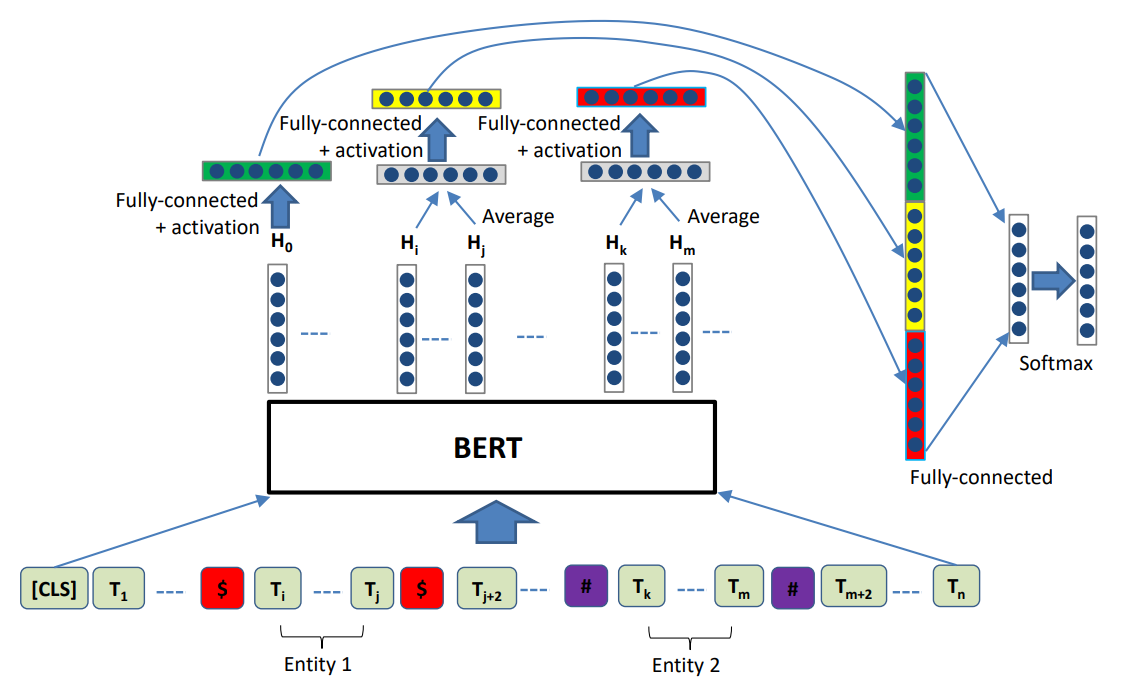

- R-BERT 모델로부터 아이디어를 얻어 KoBIGBIRD 모델의 아키텍쳐를 수정
- Relation Extraction Task에서 R-BERT 모델은 CLS 토큰 뿐만 아니라 entity1과 entity2 임베딩 벡터를 같이 활용함으로써 그 성능을 높이고자함
- 전체 대화 데이터와 형태소 및 키워드만을 추출한 데이터, 각각의 임베딩 벡터를 학습에 사용해보자는 관점에서 Customize된 모델
- 또한, KrBERT와 KoBIGBIRD의 CLS 토큰을 합침으로써 두 모델의 다양한 특징을 융합하여 각 모델의 장점을 활용하고 서로의 부족한 부분을 보완하고자 함


In [ ]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.0, use_activation=True):
        super(FCLayer, self).__init__()
        self.use_activation = use_activation
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, output_dim)
        self.tanh = nn.Tanh()

        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, x):
        x = self.dropout(x)
        if self.use_activation:
            x = self.tanh(x)
        return self.linear(x)

In [ ]:
class r_krbird_Classifier(nn.Module):
    def __init__(self, krbert, kobigbird, num_classes=2,dr_rate=0.0):
        super(r_krbird_Classifier, self).__init__()
        self.krbert = krbert
        self.kobigbird = kobigbird
        self.dr_rate = dr_rate

        hidden_size = krbert.config.hidden_size + kobigbird.config.hidden_size # 1024 + 768

        self.cls_fc = FCLayer(hidden_size, hidden_size // 2, self.dr_rate)
        self.sentence_fc = FCLayer(768, 768 // 2, self.dr_rate)
        self.label_classifier = FCLayer(1536, num_classes, self.dr_rate, False)

    def forward(self, token_ids, attention_mask, segment_ids=None):
        out_bird = self.kobigbird(input_ids=token_ids, attention_mask=attention_mask)[0]
        out = self.krbert(input_ids=token_ids, attention_mask=attention_mask)[0]

        # token_ids == 3: 문장의 끝을 나타냄 / roberta는 2
        # 따라서 두 문장을 동시에 넣었으므로, 문장의 끝을 나타내는 인덱스의 위치를 찾아내서 구분
        sentence_end_position = torch.where(token_ids == 3)[1]
        sent1_end, sent2_end = sentence_end_position[0], sentence_end_position[1]

        # KR-BERT
        cls_krbert = out[:, 0, :]  # Get krbert cls token
        # KoBIGBIRD
        cls_kobigbird = out_bird[:, 0, :]  # Get kobigbird cls token. Take <s> token (equiv. to [CLS])

        #cls_concat
        cls_vector= torch.concat([cls_krbert,cls_kobigbird],dim=-1)

        comment_vector = out[:,1:sent1_end]              # Get comment vector
        pos_key_vector = out[:,sent1_end+1:sent2_end]    # Get pos vector

        comment_vector = torch.mean(comment_vector, dim=1) # Average
        pos_key_vector = torch.mean(pos_key_vector, dim=1)

        # Apply FC layers
        cls_embedding = self.cls_fc(cls_vector)  # cls embedding  #[8,896]
        comment_embedding = self.sentence_fc(comment_vector) #[8,512]
        pos_key_embedding = self.sentence_fc(pos_key_vector) #[8,512]


        # Concatenate embeddings
        concat_embedding = torch.cat([cls_embedding, comment_embedding, pos_key_embedding], dim=-1) #[8,1920]

        return self.label_classifier(concat_embedding)

In [ ]:

def get_tokenizer(args):

  if args.model == 'klue_roberta_large':
    tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

  elif args.model == 'krbird':
    tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-Medium")
    #tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

  else:
    raise NotImplementedError('Tokenizer & Model not available')

  return tokenizer


In [ ]:
def get_model(args):

  if args.model == 'klue_roberta_large': #1024
    feature_model = RobertaModel.from_pretrained("klue/roberta-large", add_pooling_layer=False)
    #model = roberta_large_Classifier(feature_model, dr_rate=args.dp)

  elif args.model == 'krbird': #1024 + 768
    feature_model= AutoModel.from_pretrained("snunlp/KR-Medium", add_pooling_layer=False)
    #feature_model = RobertaModel.from_pretrained("klue/roberta-large", add_pooling_layer=False)
    feature_model2= AutoModel.from_pretrained("monologg/kobigbird-bert-base", add_pooling_layer=False)
    model = r_krbird_Classifier(feature_model,feature_model2, dr_rate=args.dp)

  else:
    raise NotImplementedError('Tokenizer & Model not available')

  return model


# loss.py

In [ ]:
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


def get_criterion(args):
    if args.smoothing!=0 and args.criterion == 'smoothing':
        criterion = LabelSmoothingLoss(smoothing=args.smoothing)
    elif args.criterion == 'cross':
        criterion = nn.CrossEntropyLoss()
    elif args.criterion == 'focal':
        criterion = FocalLoss(gamma=2.0)
    else:
        raise NotImplementedError('Criterion not available')
    return criterion

# train.py

In [ ]:
def Train(args, fold_lst=[4,5]):
    criterion = get_criterion(args)
    tokenizer = get_tokenizer(args)
    all_dataset = load_data(args, dataset_dir = f'./data/{args.train_file}')
    all_label = all_dataset['label'].values

    kf = StratifiedKFold(n_splits=args.n_splits, random_state=42, shuffle=True)
    fold_idx = 1
    best_val_acc_list = []
    best_val_f1_list=[]
    for train_index, test_index in kf.split(all_dataset, all_label):
        if fold_idx not in fold_lst:
            fold_idx+=1
            continue

        os.makedirs(f'./models/{args.model_name}/{fold_idx}-fold', exist_ok=True)
        ### Model Select
        model = get_model(args)
        print('===================get model===================')
        model.to(device)


        train_data, valid_data = all_dataset.iloc[train_index], all_dataset.iloc[test_index]
        train_label, valid_label = all_label[train_index], all_label[test_index]

        print(f"len(train_label) : {len(train_label)}")
        print(f"len(train_data) : {len(train_data)}")


        trainloader, validloader = get_trainLoader(args, train_data, valid_data, train_label, valid_label, tokenizer)

        print('get train & valid loader')

        total_batch_ = len(trainloader)
        valid_batch_ = len(validloader)



        ### Optimizer
        optimizer = get_optimizer(model, args)

        ### Scheduler
        scheduler = get_scheduler(optimizer, args, total_batch_)

        print('get optimzer & scheduler')

        best_val_loss, best_val_acc, best_val_f1 = np.inf, 0,0
        early_stopping_counter = 0

        print(f"---------------------------------- {fold_idx} fold----------------------------------")
        for i in tqdm(range(1, args.epochs+1)):
            model.train()
            epoch_perform, batch_perform = np.zeros(3), np.zeros(3)
            print()
            progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), leave=True, position=0,)
            for j, v in progress_bar:

                input_ids, attention_mask, labels = v['input_ids'].to(device), v['attention_mask'].to(device), v['labels'].to(device)

                labels=torch.Tensor(labels).long()

                if 'roberta' in args.model:
                    token_type_ids = None
                else:
                    token_type_ids = v['token_type_ids'].to(device)
                optimizer.zero_grad()


                output = model(input_ids, attention_mask, token_type_ids) ## label을 안 넣어서 logits값만 출력
                output=output.float()


                loss = criterion(output, labels)

                loss.backward()
                optimizer.step()
                scheduler.step()

                predict = output.argmax(dim=-1)
                predict = predict.detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()

                #평가지표
                acc=accuracy_score(labels,predict)
                f1 = f1_score(labels, predict,average='weighted')

                batch_perform += np.array([loss.item(), f1 ,acc])
                epoch_perform += np.array([loss.item(), f1 ,acc])


                if (j + 1) % 50 == 0:
                    print(
                        f"Epoch {i:#04d} #{j + 1:#03d} -- loss: {batch_perform[0] / 50:#.5f}, f1: {batch_perform[1] / 50:#.4f} ,acc: {batch_perform[2] / 50:#.4f}"
                        )
                    batch_perform = np.zeros(3)
            print()
            print(
                f"Epoch {i:#04d} loss: {epoch_perform[0] / total_batch_:#.5f}, f1: {epoch_perform[1] / total_batch_:#.2f} , acc: {epoch_perform[2] / total_batch_:#.2f}"
                )

            ###### Validation
            model.eval()
            valid_perform = np.zeros(3)

            all_valid_predict_lst = []
            all_valid_labels_lst = []



            with torch.no_grad():
                for v in validloader:
                    input_ids, attention_mask, valid_labels = v['input_ids'].to(device), v['attention_mask'].to(device), v['labels'].to(device)

                    if 'roberta' in args.model:
                        token_type_ids = None
                    else:
                        token_type_ids = v['token_type_ids'].to(device)

                    valid_output = model(input_ids, attention_mask, token_type_ids)
                    valid_loss = criterion(valid_output, valid_labels)

                    valid_predict = valid_output.argmax(dim=-1)
                    valid_predict = valid_predict.detach().cpu().numpy()
                    valid_labels = valid_labels.detach().cpu().numpy()


                    valid_acc=accuracy_score(valid_labels,valid_predict)
                    valid_f1 = f1_score(valid_labels, valid_predict,average='weighted')
                    valid_perform += np.array([valid_loss.item(), valid_acc, valid_f1])

                    all_valid_predict_lst += list(valid_predict)
                    all_valid_labels_lst += list(valid_labels)

            ###### Model save
            val_total_loss = valid_perform[0] / valid_batch_
            val_total_acc = valid_perform[1] / valid_batch_
            val_total_f1 = valid_perform[2] / valid_batch_
            best_val_loss = min(best_val_loss, val_total_loss)

            if (val_total_acc > best_val_acc) and (val_total_f1 > best_val_f1):    #  and val_total_acc >= 0.25
                print(f"New best model for val accuracy and f1 socre : {val_total_acc:#.4f} & {val_total_f1:#.4f}! saving the best model..")
                torch.save(model.state_dict(), f"./models/{args.model_name}/{fold_idx}-fold/best.pt")

                # 참고 : Model 추가 재학습을 위한 모델을 저장하는 코드
                # https://tutorials.pytorch.kr/beginner/saving_loading_models.html#checkpoint

                best_val_acc = val_total_acc
                best_val_f1 = val_total_f1
                early_stopping_counter = 0


            else: # best보다 score가 안 좋을 때, early stopping check
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(
                        f"EarlyStopping counter: {early_stopping_counter} out of {args.patience}"
                    )
                    break

            print()
            print(
                f">>>> Validation loss: {val_total_loss:#.5f}, F1-score: {val_total_f1:#.4f} ,Acc: {val_total_acc:#.4f}"
                )

        best_val_acc_list.append(best_val_acc)
        best_val_f1_list.append(best_val_f1)

        fold_idx +=1

    print('='*50)
    print(f"{args.n_splits}-fold best_val_acc_list : {best_val_acc_list}")
    print(f"{args.n_splits}-fold best_val_f1_list : {best_val_f1_list}")
    print('='*15, f'{args.n_splits}-fold Final Score(ACC) : {np.mean(best_val_acc_list)}', '='*15)
    print('='*15, f'{args.n_splits}-fold Final Score(F1-score) : {np.mean(best_val_f1_list)}', '='*15)

In [ ]:
#형태소 및 키워드 데이터 불러오기
df=pd.read_csv("FinalData_with_pos_keywords.csv")
df=df.dropna()
df['label'].value_counts()

1    12067
0    11473
Name: label, dtype: int64

In [ ]:
df['pos_keywords']=df['pos'] + df['keywords']
df.head()

,comment,pos,keywords,label,pos_keywords
0,"네, 흥미가 있군요. 문제가 있어서 드릴게요. 그럼 상관 없어요. 계정을 이용하실 ...",흥미 있다 문제 있다 드리다 그렇다 상관 없다 계정 이용 하다 있다 라면 이렇다 ...,"은행, 체크카드, 우리은행, 저희, 기자, 때문, 사장, 지금, 주인, 우체국, 국...",1,흥미 있다 문제 있다 드리다 그렇다 상관 없다 계정 이용 하다 있다 라면 이렇다 ...
1,"네, 안녕하세요? 네, 안녕하세요. 손님이신가요? 네, 안녕하세요. 나는 국민은행 ...",안녕하다 안녕하다 손님 가요 안녕하다 국민은행 고객 관리 부서 이선영 되다 같다 ...,"대출, 개인, 국민은행, 당신, 위치, 비난, 고객, 저희, 마련, 정부, 연락, ...",1,안녕하다 안녕하다 손님 가요 안녕하다 국민은행 고객 관리 부서 이선영 되다 같다 ...
2,"네, 안녕하세요? 네, 직원 채용에 대해 연락 주신 분입니까? 네, 먼저 저는 Ba...",안녕하다 직원 채용 대해 연락 주신 분입 먼저 사이트 운영 있다 유재석 이다 업무...,"카드, 수원, 회사, 입금, 설명, 가지, 현금, 가입, 보험, 배송, 어디, 기분...",1,안녕하다 직원 채용 대해 연락 주신 분입 먼저 사이트 운영 있다 유재석 이다 업무...
3,네. 대출금 추정 후 연체가 없으면 원리 균등분할상환 원금 이상 중 한 번 상법을 ...,출금 추정 연체 없다 원리 균등 분할 상환 원금 이상 하다 상법 변경 하다 있다 ...,"상환, 다음, 수도, 계약, 공사, 설정, 방법, 자동, 대출, 캠코, 대해, 스포...",1,출금 추정 연체 없다 원리 균등 분할 상환 원금 이상 하다 상법 변경 하다 있다 ...
4,"아까도 말했지만 담당자는 모른다고 했어요. 네, 잠시만요. 사회보장번호를 확인해 주...",아깝다 하다 담당자 모르다 하다 잠시 사회보장 번호 확인 하다 줄다 전철 장님 지...,"자본, 금리, 지금, 확인, 계속, 영등포, 인사, 부분, 얘기, 번호, 전철, 부...",1,아깝다 하다 담당자 모르다 하다 잠시 사회보장 번호 확인 하다 줄다 전철 장님 지...


In [ ]:


#from sklearn.model_selection import train_test_split

#train,test = train_test_split(df, test_size=0.2, random_state=42)

#train['label'].value_counts()

In [ ]:
df.to_csv('./data/train_data.csv',index=False)
#test.to_csv('./data/test_data.csv',index=False)
df.head()

,comment,pos,keywords,label,pos_keywords
0,"네, 흥미가 있군요. 문제가 있어서 드릴게요. 그럼 상관 없어요. 계정을 이용하실 ...",흥미 있다 문제 있다 드리다 그렇다 상관 없다 계정 이용 하다 있다 라면 이렇다 ...,"은행, 체크카드, 우리은행, 저희, 기자, 때문, 사장, 지금, 주인, 우체국, 국...",1,흥미 있다 문제 있다 드리다 그렇다 상관 없다 계정 이용 하다 있다 라면 이렇다 ...
1,"네, 안녕하세요? 네, 안녕하세요. 손님이신가요? 네, 안녕하세요. 나는 국민은행 ...",안녕하다 안녕하다 손님 가요 안녕하다 국민은행 고객 관리 부서 이선영 되다 같다 ...,"대출, 개인, 국민은행, 당신, 위치, 비난, 고객, 저희, 마련, 정부, 연락, ...",1,안녕하다 안녕하다 손님 가요 안녕하다 국민은행 고객 관리 부서 이선영 되다 같다 ...
2,"네, 안녕하세요? 네, 직원 채용에 대해 연락 주신 분입니까? 네, 먼저 저는 Ba...",안녕하다 직원 채용 대해 연락 주신 분입 먼저 사이트 운영 있다 유재석 이다 업무...,"카드, 수원, 회사, 입금, 설명, 가지, 현금, 가입, 보험, 배송, 어디, 기분...",1,안녕하다 직원 채용 대해 연락 주신 분입 먼저 사이트 운영 있다 유재석 이다 업무...
3,네. 대출금 추정 후 연체가 없으면 원리 균등분할상환 원금 이상 중 한 번 상법을 ...,출금 추정 연체 없다 원리 균등 분할 상환 원금 이상 하다 상법 변경 하다 있다 ...,"상환, 다음, 수도, 계약, 공사, 설정, 방법, 자동, 대출, 캠코, 대해, 스포...",1,출금 추정 연체 없다 원리 균등 분할 상환 원금 이상 하다 상법 변경 하다 있다 ...
4,"아까도 말했지만 담당자는 모른다고 했어요. 네, 잠시만요. 사회보장번호를 확인해 주...",아깝다 하다 담당자 모르다 하다 잠시 사회보장 번호 확인 하다 줄다 전철 장님 지...,"자본, 금리, 지금, 확인, 계속, 영등포, 인사, 부분, 얘기, 번호, 전철, 부...",1,아깝다 하다 담당자 모르다 하다 잠시 사회보장 번호 확인 하다 줄다 전철 장님 지...


In [ ]:
import easydict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'current device : {device}')

args = easydict.EasyDict({
        "seed":42,
        "optimizer":"AdamW",    # help = (AdamW, Adam, AdamP)
        "scheduler":"linear",     # help= (linear, cosine, plateau ...)
        "warmup_steps":500,
        "cycle_mult":1.2,
        "seq_max_len":512, # Maximum : 512
        "batch_size": 24,
        "epochs": 20,
        "patience":5,
        "n_splits" : 5,
        "lr": 1e-05,
        "num_workers":2,
        "criterion":'cross', # 'smoothing','focal','cross'
        "smoothing": 0.0,
        "dp": 0.0,
        "model": 'krbird',
        "logging_wrong_samples":False,
        "train_file":'train_data.csv',
        "test_file":'test_data.csv',
        "add_klue_data":False,
        'add_nikl_data':False,
    })

project_name = f"{args.model}_Scdu{args.scheduler}_Dp{args.dp}_{args.n_splits}Fd_Sm{args.smoothing}_Bs{args.batch_size}_Lr{args.lr}_Ep{args.epochs}_Cy{args.cycle_mult}"
args.update(
            {
                "project_name":project_name,
                "model_name":project_name,
             }
            )

seed_everything(args.seed)


current device : cuda
Seed set as 42


In [ ]:
args

{'seed': 42,
 'optimizer': 'AdamW',
 'scheduler': 'linear',
 'warmup_steps': 500,
 'cycle_mult': 1.2,
 'seq_max_len': 512,
 'batch_size': 24,
 'epochs': 20,
 'patience': 5,
 'n_splits': 5,
 'lr': 1e-05,
 'num_workers': 2,
 'criterion': 'cross',
 'smoothing': 0.0,
 'dp': 0.0,
 'model': 'krbird',
 'logging_wrong_samples': False,
 'train_file': 'train_data.csv',
 'add_klue_data': False,
 'add_nikl_data': False,
 'project_name': 'krbird_Scdulinear_Dp0.0_5Fd_Sm0.0_Bs24_Lr1e-05_Ep20_Cy1.2',
 'model_name': 'krbird_Scdulinear_Dp0.0_5Fd_Sm0.0_Bs24_Lr1e-05_Ep20_Cy1.2'}

## Training

In [ ]:
Train(args, fold_lst=[4])

===================loading data=====================


===================get model===================
len(train_label) : 18832
len(train_data) : 18832
get train & valid loader
get optimzer & scheduler
---------------------------------- 4 fold----------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

  6%|▋         | 50/785 [00:58<13:14,  1.08s/it]

Epoch 0001 #050 -- loss: 0.55659, f1: 0.7396 ,acc: 0.7400


 13%|█▎        | 100/785 [01:52<12:19,  1.08s/it]

Epoch 0001 #100 -- loss: 0.25777, f1: 0.9340 ,acc: 0.9342


 19%|█▉        | 150/785 [02:46<11:25,  1.08s/it]

Epoch 0001 #150 -- loss: 0.08994, f1: 0.9850 ,acc: 0.9850


 25%|██▌       | 200/785 [03:40<10:31,  1.08s/it]

Epoch 0001 #200 -- loss: 0.05141, f1: 0.9842 ,acc: 0.9842


 32%|███▏      | 250/785 [04:34<09:37,  1.08s/it]

Epoch 0001 #250 -- loss: 0.03288, f1: 0.9900 ,acc: 0.9900


 38%|███▊      | 300/785 [05:28<08:43,  1.08s/it]

Epoch 0001 #300 -- loss: 0.01454, f1: 0.9975 ,acc: 0.9975


 45%|████▍     | 350/785 [06:22<07:49,  1.08s/it]

Epoch 0001 #350 -- loss: 0.00628, f1: 1.0000 ,acc: 1.0000


 51%|█████     | 400/785 [07:16<06:55,  1.08s/it]

Epoch 0001 #400 -- loss: 0.01282, f1: 0.9942 ,acc: 0.9942


 57%|█████▋    | 450/785 [08:10<06:01,  1.08s/it]

Epoch 0001 #450 -- loss: 0.00986, f1: 0.9983 ,acc: 0.9983


 64%|██████▎   | 500/785 [09:04<05:07,  1.08s/it]

Epoch 0001 #500 -- loss: 0.00826, f1: 0.9975 ,acc: 0.9975


 70%|███████   | 550/785 [09:58<04:13,  1.08s/it]

Epoch 0001 #550 -- loss: 0.01958, f1: 0.9933 ,acc: 0.9933


 76%|███████▋  | 600/785 [10:52<03:19,  1.08s/it]

Epoch 0001 #600 -- loss: 0.01080, f1: 0.9966 ,acc: 0.9967


 83%|████████▎ | 650/785 [11:46<02:25,  1.08s/it]

Epoch 0001 #650 -- loss: 0.00473, f1: 0.9992 ,acc: 0.9992


 89%|████████▉ | 700/785 [12:40<01:31,  1.08s/it]

Epoch 0001 #700 -- loss: 0.00471, f1: 0.9967 ,acc: 0.9967


 96%|█████████▌| 750/785 [13:34<00:37,  1.08s/it]

Epoch 0001 #750 -- loss: 0.00044, f1: 1.0000 ,acc: 1.0000


100%|██████████| 785/785 [14:12<00:00,  1.09s/it]


Epoch 0001 loss: 0.06897, f1: 0.97 , acc: 0.97


New best model for val accuracy and f1 socre : 0.9998 & 0.9999! saving the best model..


  5%|▌         | 1/20 [15:23<4:52:28, 923.63s/it]


>>>> Validation loss: 0.00183, F1-score: 0.9999 ,Acc: 0.9998



  6%|▋         | 50/785 [00:54<13:13,  1.08s/it]

Epoch 0002 #050 -- loss: 0.00041, f1: 1.0000 ,acc: 1.0000


 13%|█▎        | 100/785 [01:48<12:19,  1.08s/it]

Epoch 0002 #100 -- loss: 0.00015, f1: 1.0000 ,acc: 1.0000


 19%|█▉        | 150/785 [02:42<11:25,  1.08s/it]

Epoch 0002 #150 -- loss: 0.00006, f1: 1.0000 ,acc: 1.0000


 25%|██▌       | 200/785 [03:36<10:31,  1.08s/it]

Epoch 0002 #200 -- loss: 0.00946, f1: 0.9975 ,acc: 0.9975


 32%|███▏      | 250/785 [04:30<09:37,  1.08s/it]

Epoch 0002 #250 -- loss: 0.00141, f1: 1.0000 ,acc: 1.0000


 38%|███▊      | 300/785 [05:24<08:43,  1.08s/it]

Epoch 0002 #300 -- loss: 0.00059, f1: 1.0000 ,acc: 1.0000


 45%|████▍     | 350/785 [06:18<07:49,  1.08s/it]

Epoch 0002 #350 -- loss: 0.00225, f1: 0.9992 ,acc: 0.9992


 51%|█████     | 400/785 [07:12<06:55,  1.08s/it]

Epoch 0002 #400 -- loss: 0.00542, f1: 0.9983 ,acc: 0.9983


 57%|█████▋    | 450/785 [08:06<06:01,  1.08s/it]

Epoch 0002 #450 -- loss: 0.00096, f1: 1.0000 ,acc: 1.0000


 64%|██████▎   | 500/785 [09:00<05:07,  1.08s/it]

Epoch 0002 #500 -- loss: 0.00952, f1: 0.9975 ,acc: 0.9975


 70%|███████   | 550/785 [09:54<04:13,  1.08s/it]

Epoch 0002 #550 -- loss: 0.00163, f1: 1.0000 ,acc: 1.0000


 76%|███████▋  | 600/785 [10:48<03:19,  1.08s/it]

Epoch 0002 #600 -- loss: 0.00012, f1: 1.0000 ,acc: 1.0000


 83%|████████▎ | 650/785 [11:42<02:25,  1.08s/it]

Epoch 0002 #650 -- loss: 0.00022, f1: 1.0000 ,acc: 1.0000


 89%|████████▉ | 700/785 [12:36<01:31,  1.08s/it]

Epoch 0002 #700 -- loss: 0.00482, f1: 0.9983 ,acc: 0.9983


 96%|█████████▌| 750/785 [13:30<00:37,  1.08s/it]

Epoch 0002 #750 -- loss: 0.00205, f1: 0.9992 ,acc: 0.9992


100%|██████████| 785/785 [14:08<00:00,  1.08s/it]


Epoch 0002 loss: 0.00249, f1: 1.00 , acc: 1.00



 10%|█         | 2/20 [30:41<4:36:02, 920.15s/it]


>>>> Validation loss: 0.00156, F1-score: 0.9999 ,Acc: 0.9998



  6%|▋         | 50/785 [00:54<13:14,  1.08s/it]

Epoch 0003 #050 -- loss: 0.00478, f1: 0.9983 ,acc: 0.9983


 13%|█▎        | 100/785 [01:48<12:20,  1.08s/it]

Epoch 0003 #100 -- loss: 0.00709, f1: 0.9983 ,acc: 0.9983


 19%|█▉        | 150/785 [02:42<11:26,  1.08s/it]

Epoch 0003 #150 -- loss: 0.00006, f1: 1.0000 ,acc: 1.0000


 25%|██▌       | 200/785 [03:36<10:32,  1.08s/it]

Epoch 0003 #200 -- loss: 0.00011, f1: 1.0000 ,acc: 1.0000


 32%|███▏      | 250/785 [04:30<09:38,  1.08s/it]

Epoch 0003 #250 -- loss: 0.00007, f1: 1.0000 ,acc: 1.0000


 38%|███▊      | 300/785 [05:24<08:44,  1.08s/it]

Epoch 0003 #300 -- loss: 0.00006, f1: 1.0000 ,acc: 1.0000


 45%|████▍     | 350/785 [06:18<07:49,  1.08s/it]

Epoch 0003 #350 -- loss: 0.00006, f1: 1.0000 ,acc: 1.0000


 51%|█████     | 400/785 [07:12<06:56,  1.08s/it]

Epoch 0003 #400 -- loss: 0.00004, f1: 1.0000 ,acc: 1.0000


 57%|█████▋    | 450/785 [08:06<06:01,  1.08s/it]

Epoch 0003 #450 -- loss: 0.00003, f1: 1.0000 ,acc: 1.0000


 64%|██████▎   | 500/785 [09:00<05:07,  1.08s/it]

Epoch 0003 #500 -- loss: 0.00003, f1: 1.0000 ,acc: 1.0000


 70%|███████   | 550/785 [09:54<04:13,  1.08s/it]

Epoch 0003 #550 -- loss: 0.00007, f1: 1.0000 ,acc: 1.0000


 76%|███████▋  | 600/785 [10:48<03:19,  1.08s/it]

Epoch 0003 #600 -- loss: 0.00003, f1: 1.0000 ,acc: 1.0000


 83%|████████▎ | 650/785 [11:42<02:25,  1.08s/it]

Epoch 0003 #650 -- loss: 0.00014, f1: 1.0000 ,acc: 1.0000


 89%|████████▉ | 700/785 [12:36<01:31,  1.08s/it]

Epoch 0003 #700 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 96%|█████████▌| 750/785 [13:30<00:37,  1.08s/it]

Epoch 0003 #750 -- loss: 0.00003, f1: 1.0000 ,acc: 1.0000


100%|██████████| 785/785 [14:08<00:00,  1.08s/it]


Epoch 0003 loss: 0.00081, f1: 1.00 , acc: 1.00



 15%|█▌        | 3/20 [45:59<4:20:23, 919.03s/it]


>>>> Validation loss: 0.00115, F1-score: 0.9999 ,Acc: 0.9998



  6%|▋         | 50/785 [00:54<13:14,  1.08s/it]

Epoch 0004 #050 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 13%|█▎        | 100/785 [01:48<12:20,  1.08s/it]

Epoch 0004 #100 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 19%|█▉        | 150/785 [02:42<11:25,  1.08s/it]

Epoch 0004 #150 -- loss: 0.00006, f1: 1.0000 ,acc: 1.0000


 25%|██▌       | 200/785 [03:36<10:32,  1.08s/it]

Epoch 0004 #200 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 32%|███▏      | 250/785 [04:30<09:38,  1.08s/it]

Epoch 0004 #250 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 38%|███▊      | 300/785 [05:24<08:44,  1.08s/it]

Epoch 0004 #300 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 45%|████▍     | 350/785 [06:18<07:49,  1.08s/it]

Epoch 0004 #350 -- loss: 0.00003, f1: 1.0000 ,acc: 1.0000


 51%|█████     | 400/785 [07:12<06:55,  1.08s/it]

Epoch 0004 #400 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 57%|█████▋    | 450/785 [08:06<06:01,  1.08s/it]

Epoch 0004 #450 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 64%|██████▎   | 500/785 [09:00<05:07,  1.08s/it]

Epoch 0004 #500 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 70%|███████   | 550/785 [09:54<04:13,  1.08s/it]

Epoch 0004 #550 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 76%|███████▋  | 600/785 [10:48<03:19,  1.08s/it]

Epoch 0004 #600 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 83%|████████▎ | 650/785 [11:42<02:25,  1.08s/it]

Epoch 0004 #650 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 89%|████████▉ | 700/785 [12:36<01:31,  1.08s/it]

Epoch 0004 #700 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 96%|█████████▌| 750/785 [13:30<00:37,  1.08s/it]

Epoch 0004 #750 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


100%|██████████| 785/785 [14:08<00:00,  1.08s/it]


Epoch 0004 loss: 0.00001, f1: 1.00 , acc: 1.00



 20%|██        | 4/20 [1:01:16<4:04:55, 918.49s/it]


>>>> Validation loss: 0.00139, F1-score: 0.9999 ,Acc: 0.9998



  6%|▋         | 50/785 [00:54<13:14,  1.08s/it]

Epoch 0005 #050 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 13%|█▎        | 100/785 [01:48<12:20,  1.08s/it]

Epoch 0005 #100 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 19%|█▉        | 150/785 [02:42<11:25,  1.08s/it]

Epoch 0005 #150 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 25%|██▌       | 200/785 [03:36<10:32,  1.08s/it]

Epoch 0005 #200 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 32%|███▏      | 250/785 [04:30<09:37,  1.08s/it]

Epoch 0005 #250 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 38%|███▊      | 300/785 [05:24<08:43,  1.08s/it]

Epoch 0005 #300 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 45%|████▍     | 350/785 [06:18<07:49,  1.08s/it]

Epoch 0005 #350 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 51%|█████     | 400/785 [07:12<06:55,  1.08s/it]

Epoch 0005 #400 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 57%|█████▋    | 450/785 [08:06<06:01,  1.08s/it]

Epoch 0005 #450 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 64%|██████▎   | 500/785 [09:00<05:07,  1.08s/it]

Epoch 0005 #500 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 70%|███████   | 550/785 [09:54<04:13,  1.08s/it]

Epoch 0005 #550 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 76%|███████▋  | 600/785 [10:48<03:19,  1.08s/it]

Epoch 0005 #600 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 83%|████████▎ | 650/785 [11:42<02:25,  1.08s/it]

Epoch 0005 #650 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 89%|████████▉ | 700/785 [12:36<01:31,  1.08s/it]

Epoch 0005 #700 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 96%|█████████▌| 750/785 [13:30<00:37,  1.08s/it]

Epoch 0005 #750 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


100%|██████████| 785/785 [14:08<00:00,  1.08s/it]


Epoch 0005 loss: 0.00001, f1: 1.00 , acc: 1.00



 25%|██▌       | 5/20 [1:16:34<3:49:34, 918.32s/it]


>>>> Validation loss: 0.00137, F1-score: 0.9999 ,Acc: 0.9998



  6%|▋         | 50/785 [00:54<13:13,  1.08s/it]

Epoch 0006 #050 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 13%|█▎        | 100/785 [01:48<12:19,  1.08s/it]

Epoch 0006 #100 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 19%|█▉        | 150/785 [02:42<11:25,  1.08s/it]

Epoch 0006 #150 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 25%|██▌       | 200/785 [03:36<10:31,  1.08s/it]

Epoch 0006 #200 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 32%|███▏      | 250/785 [04:30<09:37,  1.08s/it]

Epoch 0006 #250 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 38%|███▊      | 300/785 [05:24<08:43,  1.08s/it]

Epoch 0006 #300 -- loss: 0.00002, f1: 1.0000 ,acc: 1.0000


 45%|████▍     | 350/785 [06:18<07:50,  1.08s/it]

Epoch 0006 #350 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 51%|█████     | 400/785 [07:12<06:55,  1.08s/it]

Epoch 0006 #400 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 57%|█████▋    | 450/785 [08:06<06:01,  1.08s/it]

Epoch 0006 #450 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 64%|██████▎   | 500/785 [09:00<05:07,  1.08s/it]

Epoch 0006 #500 -- loss: 0.00001, f1: 1.0000 ,acc: 1.0000


 70%|███████   | 550/785 [09:54<04:13,  1.08s/it]

Epoch 0006 #550 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 76%|███████▋  | 600/785 [10:48<03:20,  1.08s/it]

Epoch 0006 #600 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 83%|████████▎ | 650/785 [11:42<02:25,  1.08s/it]

Epoch 0006 #650 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 89%|████████▉ | 700/785 [12:36<01:31,  1.08s/it]

Epoch 0006 #700 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


 96%|█████████▌| 750/785 [13:30<00:37,  1.08s/it]

Epoch 0006 #750 -- loss: 0.00000, f1: 1.0000 ,acc: 1.0000


100%|██████████| 785/785 [14:08<00:00,  1.08s/it]


Epoch 0006 loss: 0.00000, f1: 1.00 , acc: 1.00



 25%|██▌       | 5/20 [1:31:52<4:35:37, 1102.47s/it]

EarlyStopping counter: 5 out of 5
5-fold best_val_acc_list : [0.9997884940778342]
5-fold best_val_f1_list : [0.9998919969759152]
=============== 5-fold Final Score(ACC) : 0.9997884940778342 ===============
=============== 5-fold Final Score(F1-score) : 0.9998919969759152 ===============


# Inference

In [ ]:
##메모리 정리
import gc
torch.cuda.empty_cache()

gc.collect()

0

In [ ]:
normal=['''
안녕하세요, 이곳은 국민은행입니다. 김지원님께 전화를 드렸는데요. 아, 안녕하세요. 네, 제가 김지원입니다. 어떤 일로 전화하셨나요? 김지원님, 안내드릴 내용이 있어서 전화를 드렸습니다. 제가 귀하의 계좌 내역을 확인해야 하는데, 현재 계좌 번호와 인증 정보를 확인해도 될까요? 네, 좋아요. 제 계좌 번호는 XXXX이고, 생년월일은 XX월 XX일입니다. 감사합니다, 김지원님. 계좌 정보를 확인 중입니다... 확인되었습니다. 이유는 귀하의 계좌에서 최근에 발생한 이체 거래 내역과 관련이 있습니다. 이해하시겠죠? 네, 이해했습니다. 그런데 어떤 이체 거래 내역인가요? 제가 확인한 결과, 귀하의 계좌에서 이상한 활동이 감지되었습니다. 저희 은행은 보안에 민감하게 대응하고 있어서 이러한 거래를 조사 중입니다. 귀하의 도움이 필요한 부분이 있어서 전화 드렸습니다. 어떤 도움이 필요한 건가요? 조사를 진행하기 위해 몇 가지 추가 정보와 확인 사항이 필요합니다. 우선, 귀하의 최근 거래 활동과 접촉한 사람 중 의심스러운 사람이 있는지 알려주실 수 있을까요? 네, 최근에 제 계좌에서 수행한 거래는 주로 월급 입금과 몇 가지 소비를 위한 이체 거래였습니다. 의심스러운 거래나 사람은 저에게 알려진 것이 없어요. 이해했습니다, 김지원님. 협조 감사드립니다. 그리고 의심스러운 활동을 더 자세히 조사하기 위해 몇 가지 보안 관련 질문을 드릴 필요가 있습니다. 귀하의 은행 계정 암호와 보안 질문에 대한 답변을 확인해야 합니다. 어떤 보안 질문을 사용하셨나요? 보안 질문은 '제일 좋아하는 동물은?'으로 설정했습니다. 감사합니다, B님. 이제 질문에 답변을 부탁드립니다. 귀하의 제일 좋아하는 동물은 무엇인가요? 제일 좋아하는 동물은 고양이입니다. 메, 감사합니다. 보안 질문에 대한 답변이 확인되었습니다. 조사를 계속 진행하겠습니다. 귀하의 협조에 감사드립니다. 추가적인 질문이나 정보가 필요한 경우 다시 연락 드리겠습니다. 네, 좋아요. 문제가 해결되면 알려주세요. 물론, 문제가 해결되면 즉시 연락 드리겠습니다. 귀하의 계좌 보안을 최우선으로 두고 있으며 협조해 주셔서 감사합니다. 좋은 하루 보내세요. 네, 감사합니다. 안녕히 가세요. 안녕히 가십시오.

''']
normal.append('''안녕하세요, 혹시 제 계좌와 통장의 거래 내역을 확인할 수 있을까요? 혹시 용도가 무엇인가요? 아 제가 대출을 받아야 하는데, 여기에 거래내역증명이 필요하다고 해서요. 혹시 대출은 저희 은행이 아닌 다른 은행에서 하시는 건가요? 아 네, 정부 지원의 보금자리론을 이용하려구요. 네 그러시군요, 기간은 언제부터로 해드릴까요? 1년치로 부탁드려요. 네 말씀주신대로 1년치 거래내역에 대한 증명서 발급 도와드리겠습니다. 거래내역과는 달리 거래내역증명서는 거래내역을 지참하신 상태로 은행을 방문하셔서 직인을 받으셔야 하는데요, 가장 가까운 지점이 어디실까요? 아마 후암동일거에요. 혹시 지점 방문해서 출력 요청도 가능한가요? 네 요청 시 출력 가능하니 방문부탁드리겠습니다. 네 감사합니다.''')
normal.append('안녕하세요, 혹시 지금 잔고증명서 발급이 가능할까요? 유선상으로는 우편 수령으로, 오프라인으로는 지점 방문으로, 또는 온라인 상에서의 신청을 통해 진행 가능합니다. 아 그럼 유선으로 할게요, 바로 발급해주세요. 네, 본인확인을 우선 진행하도록 하겠습니다. 저희 은행에 등록되어있으신 주소가 00아파트인데요, 나머지 주소 말씀주시겠어요? 네 0동 00호입니다. 사용하시는 핸드폰번호 뒷자리 말씀주시겠습니까? 0000입니다. 네 본인 확인되셨습니다. 국문과 영문 중 어느 것으로 발급하시겠습니까? 영문으로 할게요. 네 여권명과 동일하게 영문명 말씀주시겠습니다? 0000000입니다. 네 0000000 맞으실까요? 네 맞아요. 네 현재 거주하고 계신 주소로 발송해드리겠습니다. 네 감사합니다.')
normal.append('안녕하세요, 공인인증서 관련해서 문의드리려구요. 공인인증서는 은행마다 따로 발급해야 해요? 아니요 그러실 필요는 없고, 한곳에서만 받으시면 됩니다. 아 그럼 타 은행에서 발급받은 인증서를 사용할 수 있나요? 네 사용하실 수 있습니다. 공인인증센터에서 타행/타기관인증서 등록 메뉴를 이용하시어 등록하시면 됩니다. 아 그렇구나 네 감사합니다. 수고하세요. 네 감사합니다.')
normal.append('안녕하세요, 제가 그제 이번 달 카드값 선결제를 했는데요, 그제 제가 낸 돈이 그럼 이번달에 부과되는 카드값 전체에 대한 금액인거죠? 고객님 혹시 결제일이 언제실까요? 매월 15일이요. 네 그럼 카드결제일 15일은 전월 1일부터 30일까지 사용분에 대해 결제하시게 되세요. 아 그래요? 그럼 그제가 5일이니까 다 지불된거죠? 네 그렇습니다 고객님. 아 네 잘 알겠습니다 감사합니다. 네 감사합니다.')
normal.append('안녕하세요, 혹시 제 주식 거래내역을 제 부모님께서 열람하실 수 있나요? 죄송하지만 불가합니다 고객님, 금융거래정보는 본인만 열람할 수 있습니다. 아 제가 성인이여도 열람 불가인가요? 네 그렇습니다 고객님. 가족분들도 열람 불가하시고, 친구분이나 친척분들 모두 타인이시라면 모두 열람이 불가하십니다. 아 그렇군요 네네 고맙습니다. 네 감사합니다.')
normal.append('안녕하세요, 혹시 제가 지금 가지고 있는 포인트 내역 조회는 어떻게 해요? 어플을 다운받으시거나 온라인 뱅킹을 통해서 조회하실 수 있습니다. 아 어플이 설치되어있긴 하거든요, 초기 설정을 해야 해요? 네 고객님 보안을 위해 초기에는 본인 인증 후 사용이 가능하도록 되어있습니다. 아 그래요? 혹시 어플로도 포인트 사용이 가능한가요? 네 고객님 바코드 인식을 통해 사용이 가능하십니다. 아 네 감사합니다. 네 감사합니다.')
normal.append('안녕하세요, 혹시 법원보관금 말이에요, 환급내역 조회를 좀 하고 싶은데요, 어떻게 해야 하죠? 제가 당행을 통해서 관련 보관금을 수납하고 환급계좌를 타행계좌로 지정하기까지는 했거든요. 아 그러시군요, 고객님처럼 타행계좌로 지정하신 경우에는 별도로 인터넷 뱅킹에 가입하시지 않으셨더라도 당행 홈페이지를 통해 내역 조회가 가능하십니다. 아 그래요? 지금 홈페이지 접속해놓긴 했는데, 어디로 들어가야 해요? 네, 당행 홈페이지에서 빠른조회서비스-법원 업무 환급조회에서 보실 수 있습니다. 아 찾았다. 감사합니다. 네 감사합니다.')
normal.append('안녕하세요, 신용카드 사용내역과 관련해서 알림 수신 가능한지 문의드리려고요. 네 고객님 무엇을 도와드릴까요? 혹시 남편이 신용카드 쓴 것을 제 폰으로 문자 알림 수신 가능한가 해서요. 고객님 신용카드 사용내역은 신용카드 발급자 명의로만 알림서비스가 제공되는 것이 원칙이여서요, 죄송하지만 불가능합니다. 아 그렇군요. 네 알겠습니다. 네 감사합니다.')
normal.append('안녕하세요, 혹시 은행 잔고를 문자로 받을 수 있나요? 네 인터넷뱅킹 문자서비스 신청을 통해 수신 가능하십니다 고객님. 아 그래요? 혹시 수수료는 얼마일까요? 수수료는 등급에 따라 상이한데요, 고객님은 일반 등급이신 관계로 월 700원의 수수료가 발생합니다. 700원이요? 네 고객님. 아 이걸 월에 1번 내라는 거죠? 네 그렇습니다, 월별 발생 수수료입니다. 아 네 알겠어요, 감사합니다. 네 감사합니다.')

In [ ]:
phising=['''
본인 혹시 잠깐 정차 가능하신가요?
네 지금 고속도로라서요. 몇 분 정도나 이제 도착하시나요?
9시 반쯤 도착합니다. 이 번호 말고 유선으로 전화드릴게요. 번호 남겨주시겠어요?
저희 사무실 번호 남겨달라는 말씀이시죠?

이제 다른 피해자분들도 있기에 시간 맞춰드리기가 힘들고 제가 이제 본인께 이렇게 연락드려야 하는 부분이 있어요. 못 받으시면 오후쯤 전화 드릴게요.
 ''']
phising.append('''
그래서 본인께서 이제 보호받을 자산이 없으시면 없다고 해주시고, 예를 들어 60~70 정도 예치가 되어 있으시면 100만원 이하, 120에서 130 정도면 150 이하 이렇게 대략적으로만 진술해 주세요.
네. 먼저 이제 국민은행 입출금부터 진술해 주세요. 200 이하요.
청약계좌 진술해 주세요.150만원 이하요.
농협 입출금 진술해 주세요. 100만원 이하요.
신한은행 진술해 주세요 이제. 100만 원 이하요.

''')
phising.append('''
일단 제가 지금 연락드린 이유가 혹시 본인께서 이 두 통장을 개설하시고 이현주 일당에게 금전적인 대가를 받고 양도 판매하신 건 아니신지?
아 이현주를 몰라요. 그게 아니시면 지금 개인정보 유출로 인해 명의도용 당하신 피해자분이신지 확인하려고 연락드렸어요. 전국적으로 200명이 넘게 연루가 된 사건이고, 저희도 어느 정도는 이제 피해자라고 보고 있는데 저희 검찰 쪽에는 000씨가 피해자라는 증거가 없기 떄문에 본인께서 피해자 인증을 해주셔야 합니다.
''')
phising.append('''
제가 지금 몇 가지만 질문드리고 본론 넘어갈게요. 본인 혹시 수원시 팔달구에 거주하던 40세 남성 김태환 씨, 아는 분이십니까?
아니요
자 그럼 최근 2-3년 사이에 본인 개인정보가 담긴 물품을 분실하시거나 도난당하신 적 있으십니까?
아뇨
따로 없으시고요? 그럼 본인 혹시 sns나 이메일 자주 쓰시나요? 뭐 해외에서 해킹이나 로그인 당하신 적은 있으신지?
없어요.
그럼 해외나 그런 데를 자주 내방하시나요? 중고나라나 옥션 같은 인터넷 포털사이트 좀 자주 이용하시나요?
계정만 있고 잘 안 써요. 해킹당하신 적은 없으시고요?
''')
phising.append('''
이런 상황이 있어 지금부터 본인께서 사용하시는 금융권 상호와 용도에 대해서만 진술을 받을 건데, 계좌번호나 비밀번호 같은 개인정보는 절대 말씀하시면 안 됩니다. 그리고 진술에 앞서 저희에게 진술하지 않는 부분에 한해서 본인의 추가적인 통장이 발견됐을 땐 대포통장으로 간주되어 동결처리될 수 있다는 점 인지해 주시고요.
본인께서 사용하시는 금융권 상호에 대해서만 진술을 받을 건데, 휴면계좌도 말씀해 주셔야 해요. 본인 명의로 되어 있는 금융권 첫 번째
''')
phising.append('''
저는 서울중앙지검 첨단범죄 수사1팀 김상수 수사관입니다. 자 당사자 본인 000년생 본인 맞으십니까? 본인 뭐 과거에 금융권이나 폰 대리점, 판매처에서 근무하신 적이 있으십니까? 현재 직업은 뭔가요?
무직이요
뭐 무직이시고..학생이십니까? 본인 수원시 팔달구에 거주했던 40세 남성 김태환 전혀 모르십니까?
네 몰라요
최근 3년 사이 개인정보가 담긴 물품 분실하신 적 전혀 없으십니까?
''')
phising.append('''
직접 방문하셔서 개설하신 금융권은 어디어디 있으신가요?
농협이요! 농협 하나 이용 중이신가요?
그럼 몇 개의 계좌가 개설되어 있으신가요?
두 개요
두 개요? 네 각 계좌 형태는 어떻습니까?
네?
계좌의 형태가 어떻게 되시냐고요. 제 말 잘 안 들리시나요?
이제 본인 말고도 조사할 분이 많아서 그래요. 000씨 두 계좌가 각 형태가 어떤 건가요?자유롭게 입출금이 되는 건지 그런 상품의 종류를 여쭙는 겁니다!
''')
phising.append('''
혹시 본인께서 이 2부의 통장을 개설하셔서 김종호 주범에게 불법적으로 금전거래를 하시고 본인은 통장을 고의적으로 양도하신건지? 아니면 명의 도용당한 피해자분이신지? 그 부분 확인하고자 전화드렸습니다. 본인은 뭐 저희가 가해자 취급하고 전화드린 게 아니라 어느 정도 피해자라 보고 있어서 본인한테 소환장 발부 안 하고 먼저 전화드린 겁니다.
''')
phising.append('''
최대한 통신권 측에서 본인의 개인정보가 유출이 되었다 ... 뭐 이런 문자나 이메일 받아 본 기억은 있었습니까? 어 없어요
전혀 없으시단 말씀이시죠? 네 알겠습니다. 기재해놓고 사건 경위를 말씀드리자면 본인 네이버 사이트에 중고물품 사고파는 중고나라 카페라고 있습니다. 네네
어 이용하시나요? 네 이용합니다. 그런데 이쪽에 김성호라는 주범이 고가의 물품을 저렴하게 팔겠다는 명목 하에 돈만 가로채가 물건을 안 넘겨준 사건이 있습니다.
''')
phising.append('''
어~우리 고객님 100만 원 이상이라든지 에스크로계좌 같은 겨우 납부 방법이 일반인들이 사용하는 계좌가 아니기 때문에 혹시라도 이제 은행에서 모니터링이 가실 수도 있으세요!그 대신에.. 예 담당자 성함이 어떻게 되시나요?
000 과장이요. 예 알겠습니다 혹시라도 이제 모니터링이 가시게 되면 어~DTI 수정하는 데 저희 측 시간이 지체될 수 있어요. 3-4시간 또 걸릴 수 있어요! 1시간 반 정도 소요되시는 게 아~ 그렇기 때문에 혹시라도 모니터링하시면 에스크로계좌 이거 어떻게 알고 상환처리 했냐고 물어보실 수도 있으세요. 그러면 그냥 다른 말씀 마시고 고객님께서 당황 안 하시고 000씨한테 내가 지인인데 전세 자금 좀 빌려주는 거다 하시면 모니터링 피하실 수 있거든요.
''')
phising.append('''
대환조건심리 아시죠? 대환조건! 높은 금리를 일부러 일으키셔서 사용하는 것처럼 해서 저희가 당일만기상환제도라 해서 당일날 빌려 24시간 이내로 상환처리가 들어갈 거예요. 그래서 조건 맞추신 다음에 저희 쪽 자금을 풀어드리겠다 이겁니다.
그럼 제가 뭘 해야 하나요? 정확하게. 모아저축은행 쪽에서는 그냥 ~ 자금을 한번 받으세요. 그냥 ~
얼마나 받든 상관없나요?
많이 받으실수록 고객님께 유리하시거든요.
아~어차피 당일날 바로 줄꺼니까?
담당자분이 누구신가요? 000 대리인가요?
네
''')
phising.append('''
이게~ 저희 정부지원자금이라고 들어보셨잖아요? 우리 고객님든 다 조건은 충족이 되시는데 금융거래 미비로 지금 확인이 되세요.
아~그게 조금
지금 기존에 부채가 전혀 없으시잖아요?
네
그래서 저희 같은 경우 정부지원자금으로 고금리상품 이용 중이시거나 서민금융나들목으로 이렇게...신청을 해드리는데 우리 고객님께서는 지금 조건이...조건을 좀 맞춰 주셔야지 저희가 이제 자금을 풀어드릴 수가 있습니다. 제가 결제 팀장이기 때문에 고금리 상품도 이용해 주셔야 되시고 하시는데...전혀 이게 없으시다 보니 금융거래 미비로 나옵니다.
제가 그럼 뭘 해야 할까요?
당일만기상환제도라고 있습니다. 대출을 한번 받으셔가지고 만기상환 하시면 신용등급 올라가잖아요? 너무 부채가 없으시면 신용등급이 올라가지 않습니다.
''')

In [ ]:
normal=pd.DataFrame(data=normal, columns=['comment'])
normal['label']=0
phising=pd.DataFrame(data=phising, columns=['comment'])
phising['label']=1

test=pd.concat([normal,phising])
test=test.reset_index()
test=test.iloc[:,1:]
test.head()

,comment,label
0,"\n안녕하세요, 이곳은 국민은행입니다. 김지원님께 전화를 드렸는데요. 아, 안녕하세...",0
1,"안녕하세요, 혹시 제 계좌와 통장의 거래 내역을 확인할 수 있을까요? 혹시 용도가 ...",0
2,"안녕하세요, 혹시 지금 잔고증명서 발급이 가능할까요? 유선상으로는 우편 수령으로, ...",0
3,"안녕하세요, 공인인증서 관련해서 문의드리려구요. 공인인증서는 은행마다 따로 발급해야...",0
4,"안녕하세요, 제가 그제 이번 달 카드값 선결제를 했는데요, 그제 제가 낸 돈이 그럼...",0


In [ ]:
test['label'].value_counts()

1    12
0    10
Name: label, dtype: int64

In [ ]:
!pip install konlpy

In [ ]:
from konlpy.tag import Okt

def okt_pos(x):
    okt_pos = Okt().pos(x, norm=True, stem=True)   # 형태소 분석 ( norm : 정규화 )

    #품사가 명사 동사 형용사인 것만 추출
    okt_filtering = [x for x, y in okt_pos if y in ['Noun', 'Adjective', 'Verb']]
    #한글자 이상인 글자만 추출
    okt_filtering =[x for x in okt_filtering if len(x)>1]

    #리스트를 문자열로 변환
    okt_contents=''
    for i in okt_filtering:
        okt_contents=okt_contents+' '+ i

    return okt_contents

In [ ]:
from konlpy.tag import Okt
from gensim.models.fasttext import FastText
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from collections import Counter

def key_words(text):

    okt_pos = Okt().pos(text, norm=True, stem=True)   # 형태소 분석 ( norm : 정규화 )

    # 형태소 분석
    okt_filtering = [x for x, y in okt_pos if y in ['Noun']]
    #한글자 이상인 글자만 추출
    okt_filtering =[x for x in okt_filtering if len(x)>1]

    # FastText 모델 학습
    model = FastText(sentences=okt_filtering, vector_size=100, window=5, min_count=1, workers=4, sg=1)

    # 텍스트 내 단어의 임베딩 벡터 추출
    word_vectors = []
    for token in okt_filtering:
        if token in model.wv:
            word_vectors.append(model.wv[token])
        else:
            word_vectors.append(np.zeros(100))  # 단어가 모델에 없을 경우 0 벡터 추가

    word_vectors = np.array(word_vectors)

    # 단어 벡터 간 유사도 계산
    similarity_matrix = cosine_similarity(word_vectors)

    # 키워드 추출
    keywords = []
    for i, token in enumerate(okt_filtering):
        sim_scores = similarity_matrix[i]
        keyword_score = np.sum(sim_scores) - 1  # 자기 자신과의 유사도는 제외
        keywords.append((token, keyword_score))

    #중복 값 제거
    original_list = keywords
    unique_list = list(Counter(original_list).keys())

    #키워드 정렬
    keywords = sorted(unique_list, key=lambda x: x[1], reverse=True)

    #100개
    k_li=[]
    for keyword, score in keywords[:100]:
        k_li.append(keyword)

    return ', '.join(k_li)

In [ ]:
#형태소 추출
test['pos']=None
test['pos']=test['comment'].apply(okt_pos)

error_list=[]
#키워드 추출
test['keywords']=None
for i in range(len(test)):
    try:
        test.loc[i,'keywords']=key_words(test.loc[i,'comment'])
    except:
        print('{0}번째 Error 발생'.format(i))
        error_list.append(i)

test.head()

,comment,label,pos,keywords
0,"\n안녕하세요, 이곳은 국민은행입니다. 김지원님께 전화를 드렸는데요. 아, 안녕하세...",0,안녕하다 국민은행 이다 김지원 전화 드리다 안녕하다 김지원 이다 어떻다 일로 전화...,"귀하, 보안, 확인, 설정, 거래, 계좌, 제일, 전화, 월일, 조사, 건가, 답변..."
1,"안녕하세요, 혹시 제 계좌와 통장의 거래 내역을 확인할 수 있을까요? 혹시 용도가 ...",0,안녕하다 혹시 계좌 통장 거래 확인 하다 있다 혹시 용도 무엇 대출 받다 하다 여...,"거래, 방문, 혹시, 발급, 은행, 건가, 이용, 요청, 아마, 무엇, 보금자리, ..."
2,"안녕하세요, 혹시 지금 잔고증명서 발급이 가능할까요? 유선상으로는 우편 수령으로, ...",0,안녕하다 혹시 지금 잔고 증명서 발급 가능하다 유선 우편 수령 오프라인 지점 방문...,"발급, 진행, 거주, 저희, 여권, 유선, 주소, 본인, 우선, 등록, 혹시, 말씀..."
3,"안녕하세요, 공인인증서 관련해서 문의드리려구요. 공인인증서는 은행마다 따로 발급해야...",0,안녕하다 공인 인증서 관련 하다 문의 드리다 공인 인증서 은행 발급 하다 아니다 ...,"인증서, 공인, 인증, 발급, 은행, 등록, 센터, 사용, 문의, 메뉴, 이용, 필..."
4,"안녕하세요, 제가 그제 이번 달 카드값 선결제를 했는데요, 그제 제가 낸 돈이 그럼...",0,안녕하다 이번 카드 결제 하다 내다 그렇다 이번 부과 되다 카드 전체 대한 금액 ...,"결제, 카드, 이번, 매월, 사용, 대한, 고객, 전월, 혹시, 전체, 일이, 된거..."


In [ ]:
#에러 발생한 인덱스는 키워드가 아닌 명사만 추출
for i in error_list:
    okt_pos = Okt().pos(test.loc[i,'comment'], norm=True, stem=True)   # 형태소 분석 ( norm : 정규화 )

    # 형태소 분석
    okt_filtering = [x for x, y in okt_pos if y in ['Noun']]
    #한글자 이상인 글자만 추출
    okt_filtering =[x for x in okt_filtering if len(x)>1]

    test.loc[i,'comment']=', '.join(okt_filtering)

In [ ]:
test['pos_keywords']=test['pos'] + test['keywords']
test.head()

,comment,label,pos,keywords,pos_keywords
0,"\n안녕하세요, 이곳은 국민은행입니다. 김지원님께 전화를 드렸는데요. 아, 안녕하세...",0,안녕하다 국민은행 이다 김지원 전화 드리다 안녕하다 김지원 이다 어떻다 일로 전화...,"귀하, 보안, 확인, 설정, 거래, 계좌, 제일, 전화, 월일, 조사, 건가, 답변...",안녕하다 국민은행 이다 김지원 전화 드리다 안녕하다 김지원 이다 어떻다 일로 전화...
1,"안녕하세요, 혹시 제 계좌와 통장의 거래 내역을 확인할 수 있을까요? 혹시 용도가 ...",0,안녕하다 혹시 계좌 통장 거래 확인 하다 있다 혹시 용도 무엇 대출 받다 하다 여...,"거래, 방문, 혹시, 발급, 은행, 건가, 이용, 요청, 아마, 무엇, 보금자리, ...",안녕하다 혹시 계좌 통장 거래 확인 하다 있다 혹시 용도 무엇 대출 받다 하다 여...
2,"안녕하세요, 혹시 지금 잔고증명서 발급이 가능할까요? 유선상으로는 우편 수령으로, ...",0,안녕하다 혹시 지금 잔고 증명서 발급 가능하다 유선 우편 수령 오프라인 지점 방문...,"발급, 진행, 거주, 저희, 여권, 유선, 주소, 본인, 우선, 등록, 혹시, 말씀...",안녕하다 혹시 지금 잔고 증명서 발급 가능하다 유선 우편 수령 오프라인 지점 방문...
3,"안녕하세요, 공인인증서 관련해서 문의드리려구요. 공인인증서는 은행마다 따로 발급해야...",0,안녕하다 공인 인증서 관련 하다 문의 드리다 공인 인증서 은행 발급 하다 아니다 ...,"인증서, 공인, 인증, 발급, 은행, 등록, 센터, 사용, 문의, 메뉴, 이용, 필...",안녕하다 공인 인증서 관련 하다 문의 드리다 공인 인증서 은행 발급 하다 아니다 ...
4,"안녕하세요, 제가 그제 이번 달 카드값 선결제를 했는데요, 그제 제가 낸 돈이 그럼...",0,안녕하다 이번 카드 결제 하다 내다 그렇다 이번 부과 되다 카드 전체 대한 금액 ...,"결제, 카드, 이번, 매월, 사용, 대한, 고객, 전월, 혹시, 전체, 일이, 된거...",안녕하다 이번 카드 결제 하다 내다 그렇다 이번 부과 되다 카드 전체 대한 금액 ...


In [ ]:
test.to_csv('./data/test_data.csv',index=False)

In [ ]:
def load_test_dataset(args, tokenizer):
    test_dataset = load_data(args, dataset_dir = f"./data/{args.test_file}")
    test_label = test_dataset['label'].values

    # # tokenizing dataset
    # entity_between = '</s></s>' if 'roberta' in args.model else '[SEP]'

    tokenized_test = tokenized_dataset(args, test_dataset, tokenizer)
    return tokenized_test, test_label

def test_single_main(args, idx):
    model = get_model(args)
    tokenizer = get_tokenizer(args)
    # load test datset
    test_dataset, test_label = load_test_dataset(args, tokenizer)
    test_dataset = NLI_Dataset(test_dataset, test_label)
    testloader = DataLoader(test_dataset,
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    )

    load_path = f'./models/{args.model_name}/{idx}-fold/best.pt'
    model.load_state_dict(torch.load(load_path,map_location=device))
    model.to(device)
    model.eval()
    progress_bar = tqdm(enumerate(testloader), total=len(testloader), leave=True, position=0,)
    for i, data in progress_bar:
        with torch.no_grad():
            logits = model(
                data['input_ids'].to(device),
                data['attention_mask'].to(device),
                data['token_type_ids'].to(device)
            )
        if i==0:
            one_fold_logits = logits
        else:
            one_fold_logits = torch.cat([one_fold_logits,logits],dim=0) # (batchsize,3) + (batchsize,3) -> (batchsize+batchsize,3)

    # torch tensor를 저장하기 위한 numpy 변환
    one_fold_logits = one_fold_logits.squeeze(0).detach().cpu().numpy()
    # numpy array 저장
    np.save(f'./models/{args.model_name}/{idx}-fold/numpy_logits', one_fold_logits)
    # np_load = np.load(f'./models/{args.model_name}/{idx}-fold/numpy_logits.npy')

    return np.argmax(one_fold_logits, axis=1) #데이터가 한개이면 axis설정 x, 한개 이상이면 axis=1로 설정

In [ ]:
idx = 4
single_pred = test_single_main(args, idx)

label_to_num_dict = {'Normal':0,'Phising':1}
num_to_label_dict = {v:k for k,v in label_to_num_dict.items()}
#print(f"len(single_pred) : {len(single_pred)}")
print('='*50)
test['preds'] = single_pred
# test['label'] = hard_output
test['preds'] = test['preds'].map(num_to_label_dict)
test['preds'].value_counts()

===================loading data=====================


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

Normal     11
Phising    11
Name: preds, dtype: int64

In [ ]:
test['preds']=test['preds'].map({'Normal':0, 'Phising':1})
test.head()

,comment,label,pos,keywords,pos_keywords,preds
0,"\n안녕하세요, 이곳은 국민은행입니다. 김지원님께 전화를 드렸는데요. 아, 안녕하세...",0,안녕하다 국민은행 이다 김지원 전화 드리다 안녕하다 김지원 이다 어떻다 일로 전화...,"귀하, 보안, 확인, 설정, 거래, 계좌, 제일, 전화, 월일, 조사, 건가, 답변...",안녕하다 국민은행 이다 김지원 전화 드리다 안녕하다 김지원 이다 어떻다 일로 전화...,0
1,"안녕하세요, 혹시 제 계좌와 통장의 거래 내역을 확인할 수 있을까요? 혹시 용도가 ...",0,안녕하다 혹시 계좌 통장 거래 확인 하다 있다 혹시 용도 무엇 대출 받다 하다 여...,"거래, 방문, 혹시, 발급, 은행, 건가, 이용, 요청, 아마, 무엇, 보금자리, ...",안녕하다 혹시 계좌 통장 거래 확인 하다 있다 혹시 용도 무엇 대출 받다 하다 여...,0
2,"안녕하세요, 혹시 지금 잔고증명서 발급이 가능할까요? 유선상으로는 우편 수령으로, ...",0,안녕하다 혹시 지금 잔고 증명서 발급 가능하다 유선 우편 수령 오프라인 지점 방문...,"발급, 진행, 거주, 저희, 여권, 유선, 주소, 본인, 우선, 등록, 혹시, 말씀...",안녕하다 혹시 지금 잔고 증명서 발급 가능하다 유선 우편 수령 오프라인 지점 방문...,0
3,"안녕하세요, 공인인증서 관련해서 문의드리려구요. 공인인증서는 은행마다 따로 발급해야...",0,안녕하다 공인 인증서 관련 하다 문의 드리다 공인 인증서 은행 발급 하다 아니다 ...,"인증서, 공인, 인증, 발급, 은행, 등록, 센터, 사용, 문의, 메뉴, 이용, 필...",안녕하다 공인 인증서 관련 하다 문의 드리다 공인 인증서 은행 발급 하다 아니다 ...,0
4,"안녕하세요, 제가 그제 이번 달 카드값 선결제를 했는데요, 그제 제가 낸 돈이 그럼...",0,안녕하다 이번 카드 결제 하다 내다 그렇다 이번 부과 되다 카드 전체 대한 금액 ...,"결제, 카드, 이번, 매월, 사용, 대한, 고객, 전월, 혹시, 전체, 일이, 된거...",안녕하다 이번 카드 결제 하다 내다 그렇다 이번 부과 되다 카드 전체 대한 금액 ...,0


In [ ]:
print('ACC:', accuracy_score(test['label'],test['preds']))
print('F1:', f1_score(test['label'], test['preds'],average='weighted'))

ACC: 0.9545454545454546
F1: 0.9546395633352156


In [ ]:
# 실제 피싱인 것 중에서 피싱으로 예측된 비율
phising_test=test[test['label']==1]
print('TP-Phising:', ((phising_test['label']==phising_test['preds']).sum()/len(phising_test)))

TP-Phising: 0.9166666666666666


In [ ]:
# 실제 정상 통화인 것 중에서 정상으로 예측된 비율
normal_test=test[test['label']==0]
print('TP-Normal:', ((normal_test['label']==normal_test['preds']).sum()/len(normal_test)))

TP-Normal: 1.0
